In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Построение рекомендательной системы на основе данных MyAnimeList.net

Предположим, что мы хотим создать свой сайт посвященный японской анимации, который предлагал бы пользователю предложения рекомендательного характера по выбору следующего тайтла для просмотра.<br><br>
Поскольку сайт у нас новый, и данных почти нет, то имеет смысл на начальном этапе воспользоваться данными другого популярного ресурса схожей тематики. В нашем случае им выступит <a href='https://myanimelist.net'>MyAnimeList.net</a> <br><br>
В дальнейшем, построив модель на основе данного сайта, мы сможем подстраивать модель под новых пользователей нашего ресурса <br>

## Данные, полученные после обкачки и первичной предобработки

### Список аниме

In [36]:
AnimeList = pd.read_csv('./data/AnimeList.csv')
AnimeList.shape

(14474, 65)

In [37]:
AnimeList.head()

,anime_id,source,episodes,duration,score,scored_by,rank,popularity,members,favorites,...,Psychological,Police,Vampire,Military,Thriller,Yaoi,Cars,Shoujo Ai,Dementia,Yuri
0,11013,0,12,24,7.63,139250,1274.0,231,283882,2809,...,0,0,0,0,0,0,0,0,0,0
1,2104,0,26,24,7.89,91206,727.0,366,204003,2579,...,0,0,0,0,0,0,0,0,0,0
2,5262,0,51,24,7.55,37129,1508.0,1173,70127,802,...,0,0,0,0,0,0,0,0,0,0
3,721,1,38,16,8.21,36501,307.0,916,93312,3344,...,0,0,0,0,0,0,0,0,0,0
4,12365,0,25,24,8.67,107767,50.0,426,182765,2082,...,0,0,0,0,0,0,0,0,0,0


In [41]:
a = np.array([1,2,3,4,5])
mask = np.array([0, 0, 1, 1, 0]).astype(bool)
a[mask]

array([3, 4])

In [9]:
AnimeList.columns

Index(['anime_id', 'source', 'episodes', 'duration', 'score', 'scored_by',
       'rank', 'popularity', 'members', 'favorites', 'studio', 'Sequel',
       'Side story', 'Alternative version', 'Prequel', 'Summary', 'Other',
       'Spin-off', 'Alternative setting', 'Character', 'Parent story',
       'Full story', 'Comedy', 'Supernatural', 'Romance', 'Shounen', 'Parody',
       'School', 'Magic', 'Shoujo', 'Drama', 'Fantasy', 'Kids', 'Action',
       'Music', 'Slice of Life', 'Josei', 'Harem', 'Shounen Ai', 'Adventure',
       'Super Power', 'Sci-Fi', 'Ecchi', 'Seinen', 'Martial Arts', 'Game',
       'Sports', 'Demons', 'Historical', 'Horror', 'Mystery', 'Samurai',
       'Hentai', 'Space', 'Mecha', 'Psychological', 'Police', 'Vampire',
       'Military', 'Thriller', 'Yaoi', 'Cars', 'Shoujo Ai', 'Dementia',
       'Yuri'],
      dtype='object')

### Обозначения:

<li>anime_id - номер тайтла вида myanimelist.net/anime/[anime_id]
<li>source - по чему снято аниме (ранобе, манга и тд)
<li>episodes - количество эпизодов
<li>duration - длительность эпизода
<li>score - оценка
<li>scored_by - сколько пользователей оценили
<li>rank - ранг
<li>popularity - популярность
<li>members - количество посмотревших
<li>favorites - количество пользователей, добавивших в избранное
<li>studio - название студии, выпустившей тайтл
<li>[Sequel - Yuri] - жанры (все остальные колонки)

### Список аниме, просмотренных каждым из пользователей с их оценкой

In [32]:
UserAnimeList = pd.read_csv('./data/UserAnimeList.csv')
UserAnimeList.shape

(60683477, 4)

In [15]:
UserAnimeList.head()

,user_id,anime_id,my_score,my_status
0,0,21,9,1
1,0,59,7,2
2,0,74,7,2
3,0,120,7,2
4,0,178,7,2


### Обозначения:

<li>user_id - идентификатор пользователя
<li>anime_id - номер тайтла вида myanimelist.net/anime/[anime_id]
<li>my_score - оценка пользователя user_id для аниме anime_id
<li>my_status - [1, 2, 3, 4, 5] : [смотрит, посмотрел, пауза, удалил, в плане]

### Пользователи

In [33]:
Users = pd.read_csv('./data/Users.csv')
Users.shape

(283044, 12)

In [20]:
Users.head()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,gender,location,stats_mean_score,birth_year,birth_month,birth_day
0,0,3,49,1,0,0,0.0,"['Chennai', 'India ']",7.43,1990.0,4.0,29.0
1,1,61,396,39,0,206,0.0,['Manila'],6.78,1995.0,1.0,1.0
2,2,45,195,27,25,59,1.0,"['Detroit', 'Michigan']",6.15,1991.0,8.0,1.0
3,3,25,414,2,5,11,1.0,"['Nayarit', 'Mexico']",8.27,1990.0,12.0,14.0
4,4,36,72,16,2,25,NaN,NaN,9.06,NaN,NaN,NaN


Обозначения не нуждаются в описании

Присутствие NaN:

In [30]:
print(Users.isnull().values.any(),
      UserAnimeList.isnull().values.any(),
      AnimeList.isnull().values.any())

True False True


Имеет смысл в дальнейшем в модели пробовать различные вариации замены NaN на определенные значения и проверку модели на кросс-валидации с новыми данными

## Взглянем на данные

### Зависимость оценки от количества эпизодов

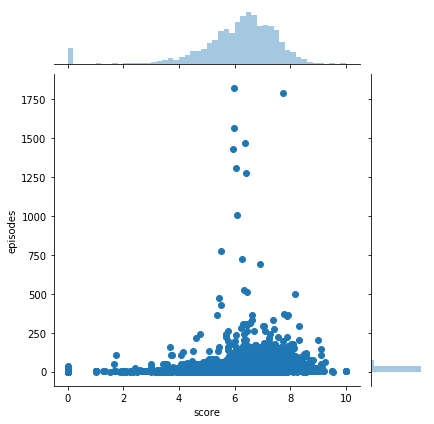

In [43]:
sns.jointplot(x='score',y='episodes', data=AnimeList)

### Распределение оценки

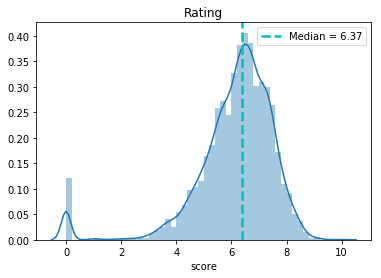

In [54]:
rating = sns.distplot(AnimeList['score'])
line = rating.axvline(np.median(AnimeList['score']), 
                    color='c', linestyle='dashed', 
                    label=('Median = '+str(round(np.median(AnimeList['score']), 2))), 
                    linewidth=2.5)
rating.set_title('Rating')
rating.legend(handles=[line])

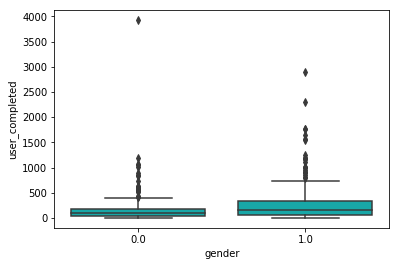

In [66]:
sns.boxplot(x="gender", y="user_completed", data=Users[:1000], color='c')

Видно, что мужской пол смотрит несколько больше <br>
Возможно, имеет смысл применять алгоритм кластеризации